In [1]:
import zipfile
import random
import numpy as np
import pandas as pd
# from ast import literal_eval
from transformers import BertTokenizer,  BertConfig, TFBertModel
import tensorflow as tf
from tensorflow.keras import backend as K
import re
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 数据集整理
## 读取数据

In [4]:
def un_zip(file_name):  
    """unzip zip file"""  
    zip_file = zipfile.ZipFile(file_name)
    for name in zip_file.namelist():  
        zip_file.extract(name,'../data')
    zip_file.close()
    dir_path = file_name.rsplit('.', 1)[0]
    return dir_path

def json_to_df(path, nrows=False):
    if nrows:
        df = pd.read_json(path, nrows=nrows, lines=True)
    else:
        df = pd.read_json(path, lines=True)
    df = df[['text', 'spo_list']]
    return df

def merge_df(path):
    if path.rsplit('.', 1)[1]=='zip':
        dir_path = un_zip(path)
    else:
        dir_path = path
    total_df = pd.DataFrame()
    for fn in os.listdir(dir_path):
        df = json_to_df(os.path.join(dir_path, fn))
        df_fn = fn[:fn.rfind('.')]
        df.insert(0, 'fn', df_fn)
        total_df =  total_df.append(df)
    total_df.reset_index(drop=True, inplace=True)
    print(f'original data size: {total_df.shape}') #
    print(f'original data sample: {df.sample(5)}')
    return total_df   

def read_schemads(path_or_df):
    if not isinstance(path_or_df, pd.DataFrame):
        print(1)
        schemads_path = path_or_df
        predicate_data = pd.read_json(schemads_path, lines=True)
        id2p = predicate_data['predicate'].drop_duplicates().reset_index(drop=True).to_dict()
    else:
        df = path_or_df
        id2p = df['spo_list'].apply(lambda spo_list: [spo['predicate'] for spo in spo_list])
        id2p = id2p.explode().drop_duplicates().reset_index(drop=True).to_dict()
    p2id = dict(zip(id2p.values(), id2p.keys()))
    print(f'length of p2id :{len(p2id)}')#
    print(f'random p2id sample:{random.sample(p2id.items(), 5)}')#
    return id2p, p2id

## 百度三元组关系数据集

In [ ]:
# train_path ='../data/百度关系抽取数据集/train_data.json'
# train_data = json_to_df(train_path, nrows=10000)
# print(f'Train data size: {train_data.shape}') #

# dev_path = '../data/百度关系抽取数据集/dev_data.json'
# dev_data = json_to_df(dev_path, nrows=5000)
# print(f'Validation data size: {dev_data.shape}') 

# schemads_path = '../data/百度关系抽取数据集/all_50_schemas'
# id2p, p2id = read_schemads(schemads_path)

## 招股说明书三元组数据集

In [6]:
path1 = './data/三元组数据集_云测标注'
df1 = merge_df(path1)

# path2 = './data/三元组数据集_内部标注.zip'
# df2 = merge_df(path2)

path3 = './data/三元组数据集_云测8.5前标注'
df3 = merge_df(path3)

df = pd.concat([df1, df3], ignore_index=True)
id2p, p2id = read_schemads(df)

original data size: (9500, 3)
original data sample:                    fn                                               text  \
105  阿科力首次公开发行股票招股说明书  江苏金羊集团有限公司的股权结构为：王锡铭持有出资3,375万元，持有67.5%的股权，胡宇星...   
39   阿科力首次公开发行股票招股说明书  2017年1-6月，公司除了原有项目外，公司新进行了低VOC涂料专用新型脂环族丙烯酸酯单体的...   
6    阿科力首次公开发行股票招股说明书  发行人曾持有济钢阿科力20%的股权。2017年8月15日，济钢阿科力的注册资本由1,000万...   
111  阿科力首次公开发行股票招股说明书  陆敏，男，1958年3月生，中国国籍，无境外永久居留权，大学专科学历。1976年至2003年...   
99   阿科力首次公开发行股票招股说明书  2008年7月14日，无锡市锡山工商行政管理局向公司换发《企业法人营业执照》，公司注册资本变...   

                                              spo_list  
105                                                 []  
39   [{'predicate': '研发费用', 'object_type': '金额', 's...  
6    [{'predicate': '注册资本', 'object_type': '金额', 's...  
111  [{'predicate': '出生日期', 'object_type': '日期', 's...  
99   [{'predicate': '注册资本', 'object_type': '金额', 's...  
original data size: (12173, 3)
original data sample:                                        fn  \
8   鼎胜新材首次公开发行A股股票招股说明书_603876_20180403_4   
6   鼎胜

## 清洗数据

In [16]:
def clean_spo(spo_list):
    for spo in spo_list:
        spo['predicate'] = spo['predicate'].lower()
        spo['subject'] = spo['subject'].lower()
        spo['object'] = spo['object'].lower()
    return spo_list

def data_clean(df):
    df.dropna(how='any', inplace=True)
    df = df[df['spo_list'].apply(lambda x: len(x)>0)]
    df.drop_duplicates(subset=['text'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['text'] = df['text'].str.lower()
    df['spo_list'] = df['spo_list'].apply(clean_spo)
    print(f'Real data size is {df.shape[0]}')
    return df

In [17]:
df = data_clean(df)
# train_data = data_clean(train_data)
# dev_data = data_clean(dev_data)

Real data size is 11990


## 划分数据集

In [18]:
train_size=0.9
train_data = df.sample(frac=train_size,random_state=200)
dev_data = df.drop(train_data.index)
dev_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)
print(f'Train data size: {train_data.shape}') #
print(f'Validation data size: {dev_data.shape}') 

spo_single_count = df['spo_list'].apply(lambda x: len(x))
spo_count = spo_single_count.sum()
print('spo_count', spo_count)

Train data size: (10791, 3)
Validation data size: (1199, 3)
spo_count 32462


In [19]:
train_text = train_data['text'].to_list()
train_spo = train_data['spo_list'].to_list()


dev_text = dev_data['text'].to_list()
dev_spo = dev_data['spo_list'].to_list()

## 标签集分布

       spo_list  count  compliance 
0  主营业务成本-日期-金额     69            0
1  主营业务收入-日期-金额    242            1
2    任职公司-人物-公司   3227            0
3    任职公司-人物-日期      1            0
4    任职日期-人物-日期   3128            0


<AxesSubplot:>

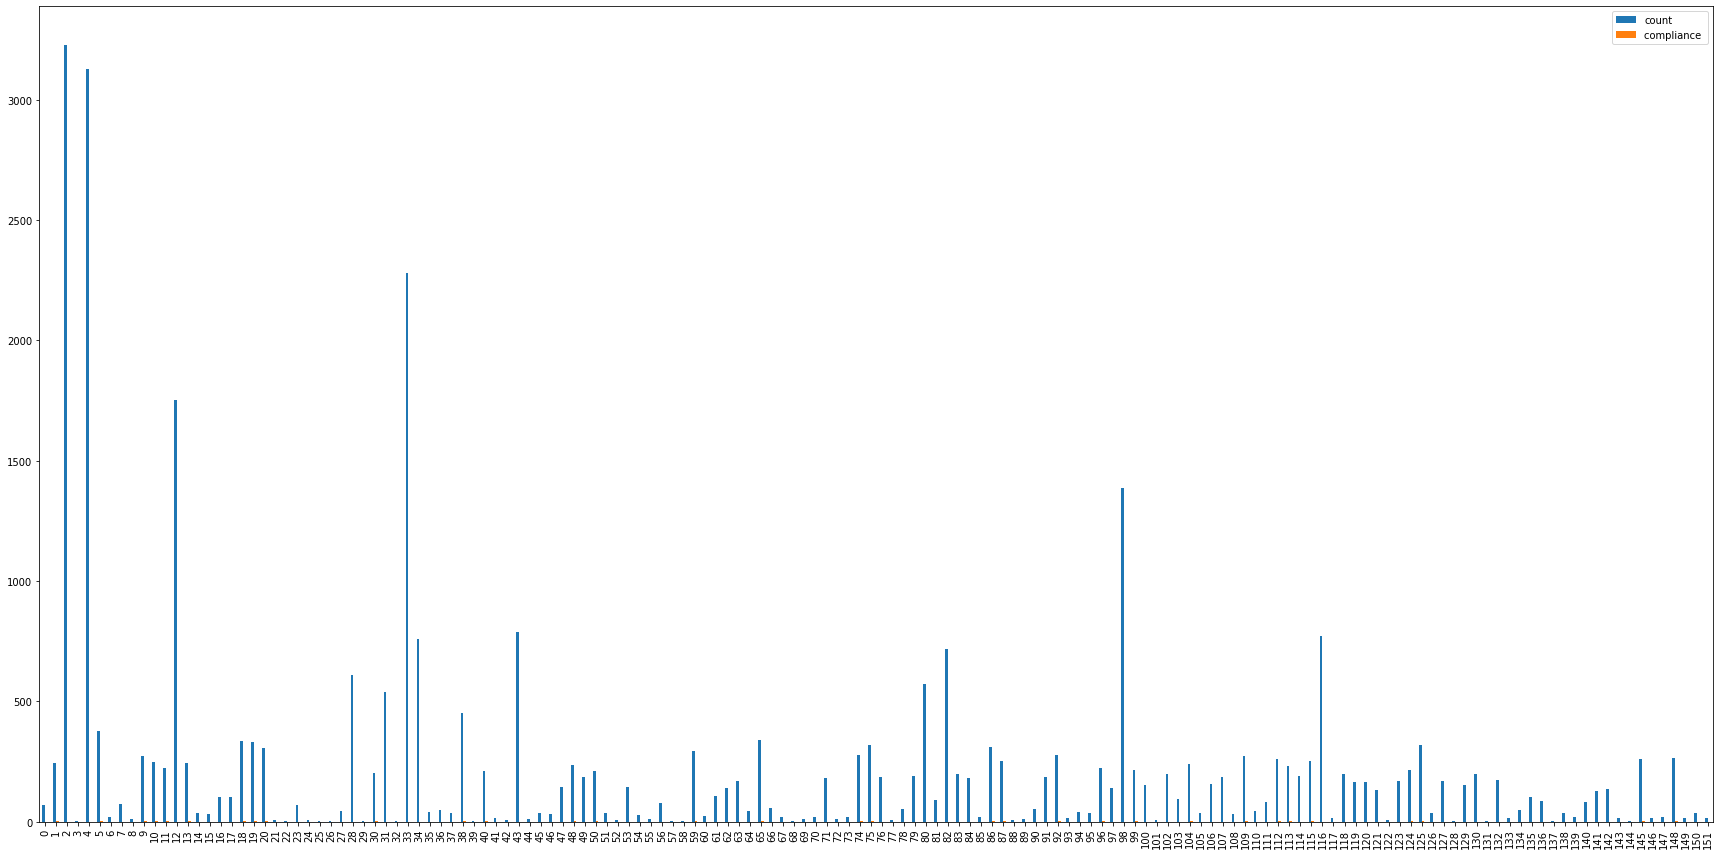

In [23]:
dataset_name = '招股说明书'
spo = df['spo_list'].explode().reset_index(drop=True)
spo_group = spo.apply(lambda x: '-'.join([x['predicate'] , x['subject_type'], x['object_type']]))
spo_group_count = spo_group.groupby(spo_group).count().reset_index(name='count')
spo_group_count['compliance '] = spo_group_count['count'].apply(lambda x: 1 if 200<x<500 else 0)
print(spo_group_count.head())
spo_group_count.to_csv('./data/' + dataset_name + '_spo_group_count.csv', index=False, encoding='utf_8_sig')
spo_group_count.plot(kind='bar', figsize=(30,15))

In [ ]:
def proceed_data(text_list, spo_list, p2id, tokenizer, MAX_LEN, spo_count):
    id_label = {}
    ct = len(text_list)
    MAX_LEN = MAX_LEN
    input_ids = np.zeros((spo_count,MAX_LEN),dtype='int32')
    attention_mask = np.zeros((spo_count,MAX_LEN),dtype='int32')
    start_tokens = np.zeros((spo_count,MAX_LEN),dtype='int32')
    end_tokens = np.zeros((spo_count,MAX_LEN),dtype='int32')
    send_s_po = np.zeros((spo_count,2),dtype='int32')
    object_start_tokens = np.zeros((spo_count,MAX_LEN,len(p2id)),dtype='int32')
    object_end_tokens = np.zeros((spo_count,MAX_LEN,len(p2id)),dtype='int32')
    index_vaild = -1
    for k in range(ct):
        context_k = text_list[k].lower().replace(' ','')
        enc_context = tokenizer.encode(context_k,max_length=MAX_LEN,truncation=True)      
        start = []
        S_index = []
        for j in range(len(spo_list[k])):
            answers_text_k = spo_list[k][j]['subject'].lower().replace(' ','')
            chars = np.zeros((len(context_k)))
            index = context_k.find(answers_text_k)
            chars[index:index+len(answers_text_k)]=1
            offsets = []
            idx=0
            for t in enc_context[1:]:
                w = tokenizer.decode([t])
                if '#' in w and len(w)>1:
                    w = w.replace('#','')
                if w == '[UNK]':
                    w = '。'
                offsets.append((idx,idx+len(w)))
                idx += len(w)
            toks = []
            for i,(a,b) in enumerate(offsets):
                sm = np.sum(chars[a:b])
                if sm>0: 
                    toks.append(i) 
            if len(toks)>0:
                S_start = toks[0]+1
                S_end = toks[-1]+1
                if (S_start,S_end) not in start:
                    index_vaild += 1
                    start.append((S_start,S_end))
                    input_ids[index_vaild,:len(enc_context)] = enc_context
                    attention_mask[index_vaild,:len(enc_context)] = 1
                    start_tokens[index_vaild,S_start] = 1
                    end_tokens[index_vaild,S_end] = 1
                    send_s_po[index_vaild,0] = S_start
                    send_s_po[index_vaild,1] = S_end
                    S_index.append([j,index_vaild])
                else:
                    S_index.append([j,index_vaild])
        if len(S_index) > 0:
            for index_ in range(len(S_index)):
                #随机选取object的首位，如果选取错误，则作为负样本
                object_text_k = spo_list[k][S_index[index_][0]]['object'].lower().replace(' ','')
                predicate = spo_list[k][S_index[index_][0]]['predicate']
                p_id = p2id[predicate]
                chars = np.zeros((len(context_k)))
                index = context_k.find(object_text_k)
                chars[index:index+len(object_text_k)]=1
                offsets = [] 
                idx = 0
                for t in enc_context[1:]:
                    w = tokenizer.decode([t])
                    if '#' in w and len(w)>1:
                        w = w.replace('#','')
                    if w == '[UNK]':
                        w = '。'
                    offsets.append((idx,idx+len(w)))
                    idx += len(w)
                toks = []
                for i,(a,b) in enumerate(offsets):
                    sm = np.sum(chars[a:b])
                    if sm>0: 
                        toks.append(i) 
                if len(toks)>0:
                    id_label[p_id] = predicate
                    P_start = toks[0]+1
                    P_end = toks[-1]+1
                    object_start_tokens[S_index[index_][1]][P_start,p_id] = 1
                    object_end_tokens[S_index[index_][1]][P_end,p_id] = 1
    return input_ids[:index_vaild], attention_mask[:index_vaild], start_tokens[:index_vaild], end_tokens[:index_vaild], send_s_po[:index_vaild], \
           object_start_tokens[:index_vaild], object_end_tokens[:index_vaild], id_label

In [ ]:
%%time
max_length = 256  
model_path = '../model_dirs/bert-base-chinese'  
tokenizer = BertTokenizer.from_pretrained(model_path)
input_ids, attention_mask, start_tokens, end_tokens, send_s_po, object_start_tokens, object_end_tokens, id_label \
= proceed_data(train_text, train_spo, p2id, tokenizer, max_length, spo_count)

print(start_tokens.shape)

val_inputs = tokenizer(dev_text, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf') 
val_input_ids, val_attention_mask = val_inputs['input_ids'], val_inputs['attention_mask']

In [ ]:
def new_loss(true,pred):
    true = tf.cast(true,tf.float32)
    loss = K.sum(K.binary_crossentropy(true, pred))
    return loss

(15605, 256)


CPU times: user 1min 31s, sys: 1.09 s, total: 1min 32s
Wall time: 1min 35s


In [ ]:
class LayerNormalization(tf.keras.layers.Layer):
    """(Conditional) Layer Normalization
    hidden_*系列参数仅为有条件输入时(conditional=True)使用
    """
    def __init__(
        self,
        center=True,
        scale=True,
        epsilon=None,
        conditional=False,
        hidden_units=None,
        hidden_activation='linear',
        hidden_initializer='glorot_uniform',
        **kwargs):
        super(LayerNormalization, self).__init__(**kwargs)
        self.center = center
        self.scale = scale
        self.conditional = conditional
        self.hidden_units = hidden_units
        self.hidden_activation = tf.keras.activations.get(hidden_activation)
        self.hidden_initializer = tf.keras.initializers.get(hidden_initializer)
        self.epsilon = epsilon or 1e-12
        
    def compute_mask(self, inputs, mask=None):
        if self.conditional:
            masks = mask if mask is not None else []
            masks = [m[None] for m in masks if m is not None]
            if len(masks) == 0:
                return None
            else:
                return K.all(K.concatenate(masks, axis=0), axis=0)
        else:
            return mask
        
    def build(self, input_shape):
        super(LayerNormalization, self).build(input_shape)
        if self.conditional:
            shape = (input_shape[0][-1],)
        else:
            shape = (input_shape[-1],)
        if self.center:
            self.beta = self.add_weight(
                shape=shape, initializer='zeros', name='beta')
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape, initializer='ones', name='gamma')
        if self.conditional:
            if self.hidden_units is not None:
                self.hidden_dense = tf.keras.layers.Dense(
                    units=self.hidden_units,
                    activation=self.hidden_activation,
                    use_bias=False,
                    kernel_initializer=self.hidden_initializer)
            if self.center:
                self.beta_dense = tf.keras.layers.Dense(
                    units=shape[0], use_bias=False, kernel_initializer='zeros')
            if self.scale:
                self.gamma_dense = tf.keras.layers.Dense(
                    units=shape[0], use_bias=False, kernel_initializer='zeros')

    def call(self, inputs):
        """如果是条件Layer Norm，则默认以list为输入，第二个是condition
        """
        if self.conditional:
            inputs, cond = inputs
            if self.hidden_units is not None:
                cond = self.hidden_dense(cond)
            for _ in range(K.ndim(inputs) - K.ndim(cond)):
                cond = K.expand_dims(cond, 1)
            if self.center:
                beta = self.beta_dense(cond) + self.beta
            if self.scale:
                gamma = self.gamma_dense(cond) + self.gamma
        else:
            if self.center:
                beta = self.beta
            if self.scale:
                gamma = self.gamma
        outputs = inputs
        if self.center:
            mean = K.mean(outputs, axis=-1, keepdims=True)
            outputs = outputs - mean
        if self.scale:
            variance = K.mean(K.square(outputs), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            outputs = outputs / std
            outputs = outputs * gamma
        if self.center:
            outputs = outputs + beta
        return outputs


In [ ]:
def extract_subject(inputs):
    """根据subject_ids从output中取出subject的向量表征
    """
    output, subject_ids = inputs
    start = tf.gather(output,subject_ids[:,0],axis=1,batch_dims=1)
    end = tf.gather(output,subject_ids[:,1],axis=1,batch_dims=1)
    subject = tf.keras.layers.Concatenate(axis=1)([start, end])
    return subject
'''
   output.shape = (None,128,768)
   subjudec_ids.shape = (None,2)
   start.shape = (None,None,768)
   subject.shape = (None,None,1536)
   subject[:,0].shape = (None,1536)
   这一部分给出各个变量的shape应该一目了然
'''
   
def build_model_2(pretrained_path, MAX_LEN, p2id):
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    s_po_index =  tf.keras.layers.Input((2,), dtype=tf.int32)
    
    bert_model = TFBertModel.from_pretrained(pretrained_path, output_hidden_states=True)
    outputs = bert_model(ids, attention_mask=att)
    x, _, hidden_states  = outputs[:3]
    layer_1 = hidden_states[-1]
    start_logits = tf.keras.layers.Dense(1,activation = 'sigmoid')(layer_1)
    start_logits = tf.keras.layers.Lambda(lambda x: x**2)(start_logits)
    
    end_logits = tf.keras.layers.Dense(1,activation = 'sigmoid')(layer_1)
    end_logits = tf.keras.layers.Lambda(lambda x: x**2)(end_logits)
    
    subject_1 = extract_subject([layer_1,s_po_index])
    Normalization_1 = LayerNormalization(conditional=True)([layer_1, subject_1])
    
    op_out_put_start = tf.keras.layers.Dense(len(p2id),activation = 'sigmoid')(Normalization_1)
    op_out_put_start = tf.keras.layers.Lambda(lambda x: x**4)(op_out_put_start)
    
    op_out_put_end = tf.keras.layers.Dense(len(p2id),activation = 'sigmoid')(Normalization_1)
    op_out_put_end = tf.keras.layers.Lambda(lambda x: x**4)(op_out_put_end)
    
    model = tf.keras.models.Model(inputs=[ids, att, s_po_index], outputs=[start_logits, end_logits, op_out_put_start, op_out_put_end])
    model_2 = tf.keras.models.Model(inputs=[ids, att], outputs=[start_logits,end_logits])
    model_3 = tf.keras.models.Model(inputs=[ids, att, s_po_index], outputs=[op_out_put_start, op_out_put_end])
    return model, model_2, model_3


In [ ]:
def rematch_text_word(tokenizer,text,enc_context,enc_start,enc_end):
    span = [a.span()[0] for a in re.finditer(' ', text)]
    decode_list = [tokenizer.decode([i]) for i in enc_context][1:]
    start = 0
    end = 0
    len_start = 0
    for i in range(len(decode_list)):
        if i ==  enc_start - 1:
            start = len_start
        j = decode_list[i]
        if '#' in j and len(j)>1:
            j = j.replace('#','')
        if j == '[UNK]':
            j = '。'
        len_start += len(j)
        if i == enc_end - 1:
            end = len_start
            break
    for span_index in span:
        if start >= span_index:
            start += 1
            end += 1
        if end > span_index and span_index>start:
            end += 1
    return text[start:end]


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self,model_2, model_3, id2tag, va_text_list, va_spo_list, va_input_ids, va_attention_mask, tokenizer):
        super(Metrics, self).__init__()
        self.model_2 = model_2
        self.model_3 = model_3
        self.id2tag = id2tag
        self.va_input_ids = va_input_ids
        self.va_attention_mask = va_attention_mask
        self.va_spo_list = va_spo_list
        self.va_text_list = va_text_list
        self.tokenizer = tokenizer
        
    def on_train_begin(self, logs=None):
        self.val_f1s = []
        self.best_val_f1 = 0
    
    def get_same_element_index(self,ob_list):
        return [i for (i, v) in enumerate(ob_list) if v == 1]
    
    def evaluate_data(self):
        Y1 = self.model_2.predict([self.va_input_ids,self.va_attention_mask])
        question=[]
        answer=[]
        for m in range(len(Y1[0])):
            for z in self.va_spo_list[m]:
                question.append((z['subject'],z['predicate'],z['object']))
            start = np.where(Y1[0][m]>0.5)[0]
            end = np.where(Y1[1][m]>0.5)[0]
            subjects = []
            for i in start:
                j = end[end >= i]
                if len(j) > 0:
                    j = j[0]
                    subjects.append((i, j))
            if subjects:
                token_ids_2 = np.repeat([self.va_input_ids[m]], len(subjects), 0)
                attention_mask_2 = np.repeat([self.va_attention_mask[m]], len(subjects), 0)
                subjects = np.array(subjects)
                object_preds_start,object_preds_end = self.model_3.predict([token_ids_2, attention_mask_2, subjects])
                for subject,object_start,object_end in zip(subjects,object_preds_start,object_preds_end):
                    sub = rematch_text_word(self.tokenizer,self.va_text_list[m],self.va_input_ids[m],subject[0],subject[1])
                    start = np.argwhere(object_start > 0.5)
                    end = np.argwhere(object_end > 0.5)
                    for _start, predicate1 in start:
                        for _end, predicate2 in end:
                            if _start <= _end and predicate1 == predicate2:
                                ans = rematch_text_word(self.tokenizer,self.va_text_list[m],self.va_input_ids[m],_start,_end)
                                answer.append((sub,self.id2tag[predicate1],ans))
                                break
        Q = set(question)
        S = set(answer)
        f1 = 2*len(Q&S)/(len(Q)+len(S))
        return f1
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        _val_f1 = self.evaluate_data()
        self.val_f1s.append(_val_f1)
        logs['val_f1'] = _val_f1
        if _val_f1 > self.best_val_f1:
            self.model.save_weights('../model_dirs/fine_tune_relation_extraction/09_f1={}_model.hdf5'.format(round(_val_f1,4)))
            self.best_val_f1 = _val_f1
            print("best f1: {} \n".format(self.best_val_f1))
        else:
            print("val f1: {}, but not the best f1 \n".format(_val_f1))
        return      

In [ ]:
pretrained_path = '../model_dirs/bert-base-chinese'
MAX_LEN = max_length
# config = BertConfig.from_json_file('../model_dirs/bert-base-chinese/config.json')
# TFBertModel.from_pretrained(pretrained_path, config=config)
K.clear_session()
model,model_2,model_3 = build_model_2(pretrained_path,  MAX_LEN, p2id)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss={'lambda': new_loss,
                'lambda_1': new_loss,
                'lambda_2': new_loss,
                'lambda_3': new_loss},optimizer=optimizer)
model.fit([input_ids, attention_mask, send_s_po], [start_tokens, end_tokens, object_start_tokens, object_end_tokens], \
        epochs=20, batch_size=2, callbacks=[Metrics(model_2, model_3 ,id2p, dev_text, dev_spo, val_input_ids, val_attention_mask, tokenizer)])

h5_path = '../model_dirs/fine_tune_relation_extraction/tf_model.h5'
model.save_weights(h5_path)
checkpoint_path = '../model_dirs/fine_tune_relation_extraction/checkpoints/my_checkpoint'
model.save_weights(checkpoint_path)

Some layers from the model checkpoint at ../model_dirs/bert-base-chinese were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ../model_dirs/bert-base-chinese.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/20


ResourceExhaustedError:  OOM when allocating tensor with shape[4,12,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul (defined at /home/nan/miniconda3/envs/py3.7/lib/python3.7/site-packages/transformers/models/bert/modeling_tf_bert.py:259) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_29860]

Errors may have originated from an input operation.
Input Source operations connected to node model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul:
 model/tf_bert_model/bert/encoder/layer_._10/attention/self/transpose (defined at /home/nan/miniconda3/envs/py3.7/lib/python3.7/site-packages/transformers/models/bert/modeling_tf_bert.py:239)

Function call stack:
train_function


In [ ]:
pretrained_path = '../model_dirs/bert-base-chinese'
checkpoint_path = '../model_dirs/fine_tune_relation_extraction/checkpoints/my_checkpoint'
h5_path = '../model_dirs/fine_tune_relation_extraction/tf_model.h5'
MAX_LEN = max_length
model,model_2,model_3 = build_model_2(pretrained_path, MAX_LEN, p2id)
model.load_weights(h5_path)

In [ ]:
idx = 0
x1 = [input_ids[[idx]], attention_mask[[idx]]]
sub_start_tokens, sub_end_tokens = model_2.predict(x1)
train_spo[idx], p2id[train_spo[idx][0]['predicate']]

In [ ]:
sub_start_idx = int(np.argwhere(sub_start_tokens[0,:,0] > 0.5)[0])
sub_end_idx = int(np.argwhere(sub_end_tokens[0,:,0] > 0.5)[0])
sub_text = tokenizer.decode(input_ids[idx][sub_start_idx:sub_end_idx+1]).replace(' ','')
sub_text

In [ ]:
x2 = [input_ids[[idx]], attention_mask[[idx]], send_s_po[[idx]]]
obj_start_tokens, obj_end_tokens = model_3.predict(x2)
obj_start_tokens.shape

In [ ]:
obj_start_idx = np.argwhere(obj_start_tokens[0] > 0.5)
obj_end_idx = np.argwhere(obj_end_tokens[0] > 0.5)
for _start, predicate1 in obj_start_idx:
    for _end, predicate2 in obj_end_idx:
        if _start <= _end and predicate1 == predicate2:
            print(_start, _end, predicate1)
            obj_text = tokenizer.decode(input_ids[idx][_start:_end+1]).replace(' ','')
            print(obj_text, id2p[predicate1])

In [ ]:
import os
pid = os.getpid()
!kill -9 $pid

In [ ]:
!nvidia-smi

Error: Session cannot generate requests